### Building graph based on tags from question posts. 

Can we find connection between tags used in the stackoverflow questions?
I had a simple idea to build a graph based on co-occurences of tags in Python-related questions. Tags in the question posts often represent tools, libraries and tecnical fields (e.g. machine-learning). Maybe, this type of graph unlock some interesting findings for us.

DataQubit

March, 2019

In [ ]:
import numpy as np
import pandas as pd
import bq_helper
from bq_helper import BigQueryHelper
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")

In [ ]:
import networkx as nx
from itertools import combinations

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")

In [ ]:
bq_assistant.head("posts_questions", num_rows=5)

In [ ]:
# for future study we may need the folllowing columns
cols_of_interest = ['id', 'creation_date', 'last_activity_date', 
    'owner_user_id', 'score', 'tags','view_count']

In [ ]:
# SQL query to extract Python & R questions
query_python_posts = """
SELECT %s,
    REGEXP_CONTAINS(tags, r'python') AS is_python,
    REGEXP_CONTAINS(tags, r'%s') AS is_r
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
WHERE
    REGEXP_CONTAINS(tags, r'python') OR
    REGEXP_CONTAINS(tags, r'%s')
""" %(','.join(cols_of_interest), r'\br\b', r'\br\b')
# check the size of this query
stackOverflow.estimate_query_size(query_python_posts)

In [ ]:
# save results to a dataframe
df_python_r = stackOverflow.query_to_pandas_safe(query_python_posts, max_gb_scanned=3.0)

In [55]:
df_python_r.head()

,id,creation_date,last_activity_date,owner_user_id,score,tags,view_count,is_python,is_r
0,29314033,2015-03-28 05:30:48.690000+00:00,2018-06-11 18:34:23.030000+00:00,3923448.0,34,python|pandas,85034,True,False
1,42299352,2017-02-17 13:36:19.100000+00:00,2018-11-06 12:15:51.640000+00:00,2666270.0,11,python|macos|matplotlib-basemap,10621,True,False
2,23549195,2014-05-08 17:57:37.763000+00:00,2015-04-06 16:06:11.307000+00:00,851182.0,9,python|matplotlib,1977,True,False
3,17758455,2013-07-20 03:48:01.140000+00:00,2013-07-27 04:45:04.343000+00:00,2601341.0,-4,r|plot,1637,False,True
4,3110166,2010-06-24 13:05:53.847000+00:00,2016-03-11 02:17:33.560000+00:00,131383.0,46,python|django|templates|ternary-operator,18066,True,False


In [ ]:
len(df_python_r), df_python_r.is_python.sum(), df_python_r.is_r.sum()

### Experimenting with the first 1000 rows before using the whole dataset.

In [56]:
# Tag Graph Python
tagGr_python = nx.Graph()
for tags_str in df_python_r[df_python_r.is_python].tags.iloc[:1000]:
    tags = tags_str.split('|')
    # adding nodes
    for tag in tags:
        if tag in tagGr_python.nodes():
            tagGr_python.nodes[tag]['size'] += 1
        else:
            tagGr_python.add_node(tag, size=1)

    # adding edges:
    for u, v in combinations(tags, 2):
        if (u, v) in tagGr_python.edges():
            tagGr_python[u][v]['weight'] += 1
        else:
            tagGr_python.add_edge(u, v, weight=1)

In [25]:
df_python_r[df_python_r.is_python].tags.iloc[:10]

0                                python|pandas
1              python|macos|matplotlib-basemap
2                            python|matplotlib
4     python|django|templates|ternary-operator
6                                 python|numpy
7                           python|string|pep8
8                            python|string|int
10             python|c++|opencv|tesseract|cv2
12                         python|arrays|numpy
13                      python|google-bigquery
Name: tags, dtype: object

In [50]:
tagGr_python.edges(data=True)

EdgeDataView([('python', 'pandas', {'weight': 4}), ('python', 'macos', {'weight': 2}), ('python', 'matplotlib-basemap', {'weight': 1}), ('python', 'matplotlib', {'weight': 6}), ('python', 'django', {'weight': 10}), ('python', 'templates', {'weight': 1}), ('python', 'ternary-operator', {'weight': 1}), ('python', 'numpy', {'weight': 10}), ('python', 'string', {'weight': 4}), ('python', 'pep8', {'weight': 1}), ('python', 'int', {'weight': 1}), ('python', 'c++', {'weight': 1}), ('python', 'opencv', {'weight': 1}), ('python', 'tesseract', {'weight': 1}), ('python', 'cv2', {'weight': 1}), ('python', 'arrays', {'weight': 3}), ('python', 'google-bigquery', {'weight': 1}), ('python', 'amazon-web-services', {'weight': 1}), ('python', 'amazon-dynamodb', {'weight': 1}), ('python', 'django-admin', {'weight': 1}), ('python', 'lambda', {'weight': 1}), ('python', 'partial', {'weight': 1}), ('python', 'functools', {'weight': 1}), ('python', 'autocomplete', {'weight': 1}), ('python', 'python-jedi', {'we

In [51]:
tagGr_python.nodes(data=True)

NodeDataView({'python': {'size': 97}, 'pandas': {'size': 4}, 'macos': {'size': 2}, 'matplotlib-basemap': {'size': 1}, 'matplotlib': {'size': 6}, 'django': {'size': 10}, 'templates': {'size': 1}, 'ternary-operator': {'size': 1}, 'numpy': {'size': 11}, 'string': {'size': 4}, 'pep8': {'size': 1}, 'int': {'size': 1}, 'c++': {'size': 1}, 'opencv': {'size': 2}, 'tesseract': {'size': 1}, 'cv2': {'size': 1}, 'arrays': {'size': 4}, 'google-bigquery': {'size': 1}, 'amazon-web-services': {'size': 1}, 'amazon-dynamodb': {'size': 1}, 'django-admin': {'size': 1}, 'lambda': {'size': 1}, 'partial': {'size': 1}, 'functools': {'size': 1}, 'autocomplete': {'size': 1}, 'python-jedi': {'size': 1}, 'list': {'size': 7}, 'replace': {'size': 1}, 'urllib': {'size': 1}, 'scrapy': {'size': 1}, 'python-2.7': {'size': 5}, 'machine-learning': {'size': 2}, 'out-of-memory': {'size': 1}, 'ipython': {'size': 1}, 'python-3.x': {'size': 9}, 'anaconda': {'size': 1}, 'datetime': {'size': 1}, 'concatenation': {'size': 1}, 'g

In [57]:
node_size = np.array([item[1]['size'] for item in tagGr_python.nodes(data=True)])

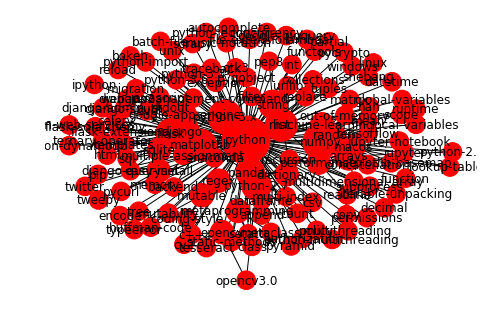

In [54]:
nx.draw(tagGr_python, with_labels=True, node_size=500 * np.log(node_size + 1), pos=nx.spring_layout(tagGr_python), k=0.95)

In [58]:
len(tagGr_python.nodes())

822

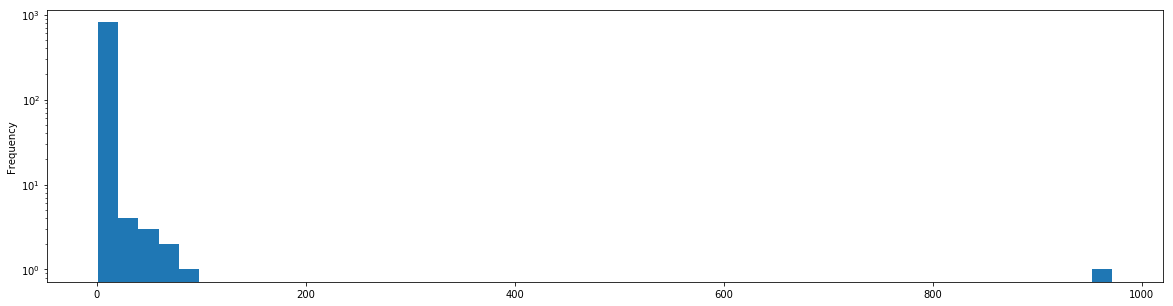

In [62]:
pd.Series(node_size).plot(kind='hist', figsize=(20, 5), bins=50, logy=True)

In [71]:
sum(node_size > 5)

63

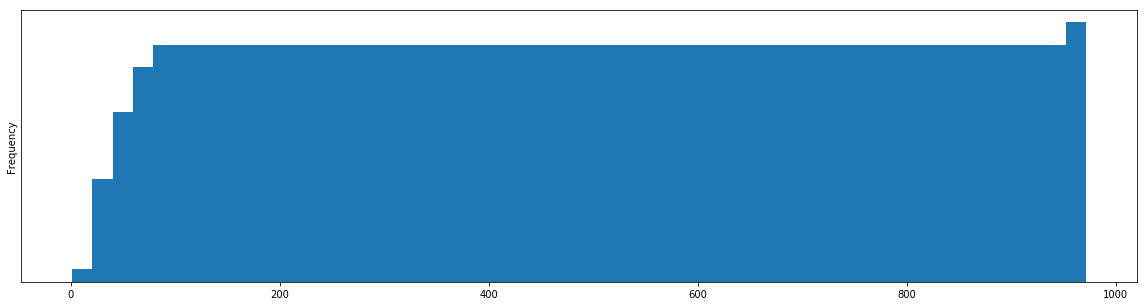

In [63]:
pd.Series(node_size).plot(kind='hist', figsize=(20, 5), bins=50, logy=True, cumulative=True)

#### Keeping only 'significant' nodes (e.g. those which appear more than 5 times in this case)

In [72]:
sig_nodes = [node for node, attr in tagGr_python.nodes(data=True) if attr['size'] > 5]
sigGr = tagGr_python.subgraph(sig_nodes)

In [73]:
sigGr.nodes(data=True)

NodeDataView({'string': {'size': 23}, 'iteration': {'size': 6}, 'django-templates': {'size': 8}, 'keras': {'size': 10}, 'matplotlib': {'size': 37}, 'datetime': {'size': 13}, 'multiprocessing': {'size': 8}, 'pycharm': {'size': 6}, 'json': {'size': 10}, 'python': {'size': 972}, 'pip': {'size': 17}, 'scikit-learn': {'size': 10}, 'tuples': {'size': 13}, 'javascript': {'size': 6}, 'python-2.7': {'size': 47}, 'python-3.x': {'size': 85}, 'tkinter': {'size': 10}, 'list-comprehension': {'size': 7}, 'windows': {'size': 12}, 'class': {'size': 6}, 'google-app-engine': {'size': 9}, 'anaconda': {'size': 6}, 'numpy': {'size': 60}, 'csv': {'size': 6}, 'flask': {'size': 18}, 'performance': {'size': 10}, 'tensorflow': {'size': 22}, 'function': {'size': 9}, 'regex': {'size': 13}, 'algorithm': {'size': 6}, 'debugging': {'size': 7}, 'shell': {'size': 6}, 'file': {'size': 7}, 'scipy': {'size': 15}, 'unix': {'size': 6}, 'ipython': {'size': 6}, 'argparse': {'size': 6}, 'r': {'size': 8}, 'unicode': {'size': 6}

In [74]:
node_size_sigGr = np.array([item[1]['size'] for item in sigGr.nodes(data=True)])

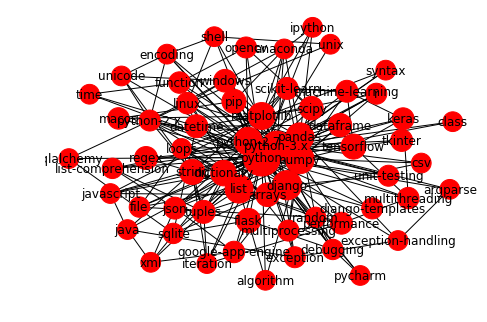

In [76]:
nx.draw(sigGr, with_labels=True, node_size=200 * np.log(node_size_sigGr + 1), pos=nx.spring_layout(sigGr), k=0.95)

### Total Python Graph (from all python questions)

In [77]:
# Tag Graph Python
pythGr = nx.Graph()
for tags_str in df_python_r[df_python_r.is_python].tags:
    tags = tags_str.split('|')
    # adding nodes
    for tag in tags:
        if tag in pythGr.nodes():
            pythGr.nodes[tag]['size'] += 1
        else:
            pythGr.add_node(tag, size=1)

    # adding edges:
    for u, v in combinations(tags, 2):
        if (u, v) in pythGr.edges():
            pythGr[u][v]['weight'] += 1
        else:
            pythGr.add_edge(u, v, weight=1)

In [80]:
len(pythGr.nodes()), len(pythGr.edges())

(21823, 475086)

In [81]:
node_size_pythGr = pd.Series([item[1]['size'] for item in pythGr.nodes(data=True)])

#### Distribution of node size

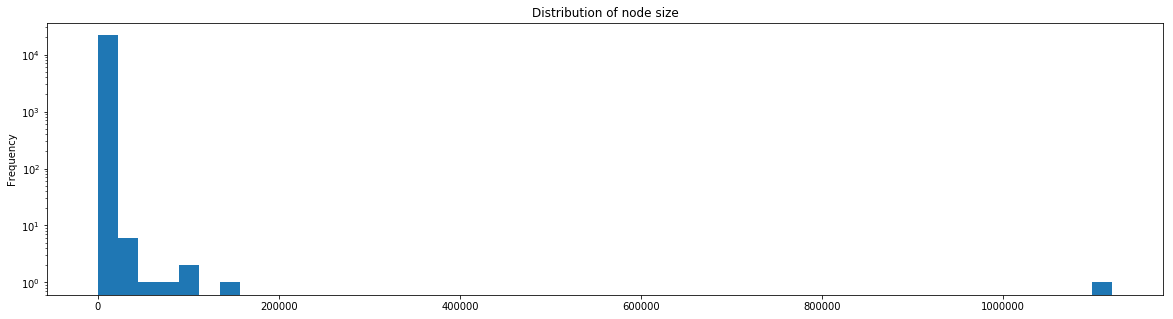

In [87]:
node_size_pythGr.plot(kind='hist', figsize=(20, 5), logy=True, bins=50, title='Distribution of node size')
plt.show()

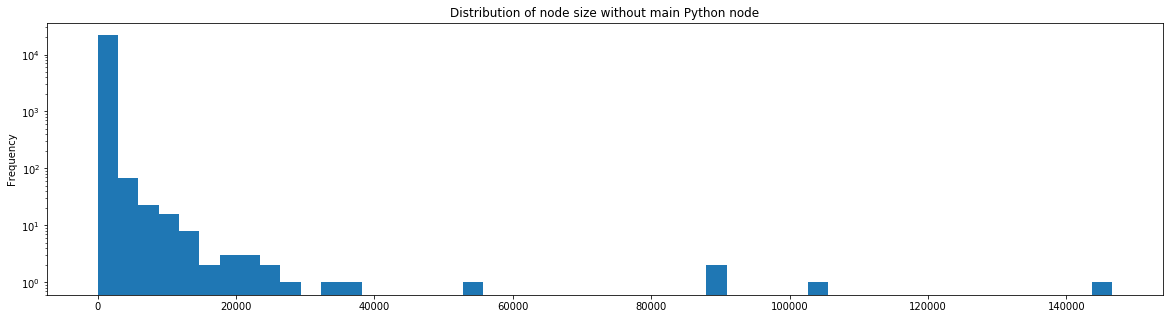

In [88]:
node_size_pythGr[node_size_pythGr < 1.e6].plot(kind='hist', figsize=(20, 5), logy=True, bins=50, title='Distribution of node size without main Python node')
plt.show()

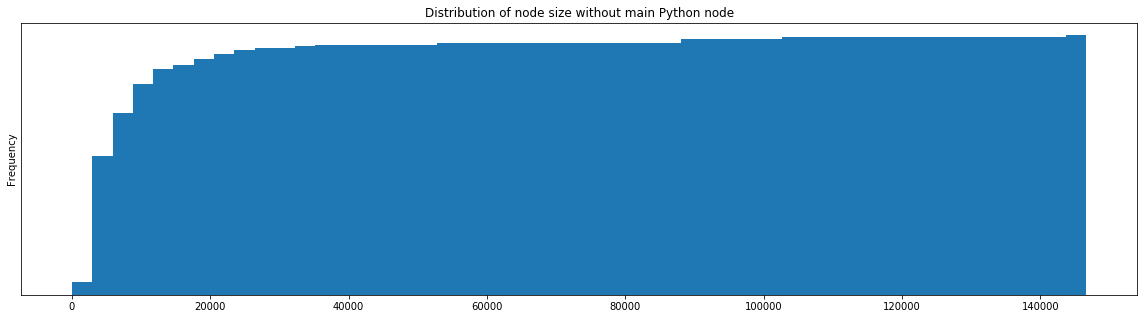

In [93]:
node_size_pythGr[node_size_pythGr < 1.e6].plot(kind='hist', figsize=(20, 5), logy=True, bins=50, title='Distribution of node size without main Python node',
                                              cumulative=True)
plt.show()

 #### Top 15 most frequent nodes:

In [91]:
sorted(pythGr.nodes(data=True), key=lambda x: x[1]['size'], reverse=True)[:15]

[('python', {'size': 1120815}),
 ('python-3.x', {'size': 146659}),
 ('django', {'size': 104119}),
 ('pandas', {'size': 90291}),
 ('python-2.7', {'size': 88895}),
 ('numpy', {'size': 54233}),
 ('list', {'size': 37596}),
 ('matplotlib', {'size': 33539}),
 ('dictionary', {'size': 26706}),
 ('regex', {'size': 24627}),
 ('dataframe', {'size': 24369}),
 ('tkinter', {'size': 23275}),
 ('flask', {'size': 22141}),
 ('tensorflow', {'size': 21634}),
 ('string', {'size': 19844})]

In [97]:
# number of nodes appearing more than 100 times:
(node_size_pythGr > 100).sum()

2185

 #### Top 15 most frequent edges:

In [98]:
sorted(pythGr.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:15]

[('python', 'django', {'weight': 97687}),
 ('python', 'python-3.x', {'weight': 91374}),
 ('python', 'pandas', {'weight': 84417}),
 ('python', 'python-2.7', {'weight': 57813}),
 ('python', 'numpy', {'weight': 51477}),
 ('python', 'list', {'weight': 35681}),
 ('python', 'matplotlib', {'weight': 31223}),
 ('python', 'dictionary', {'weight': 25373}),
 ('python', 'regex', {'weight': 23180}),
 ('python', 'dataframe', {'weight': 22971}),
 ('pandas', 'dataframe', {'weight': 21693}),
 ('python', 'flask', {'weight': 20867}),
 ('python', 'tkinter', {'weight': 20504}),
 ('python', 'tensorflow', {'weight': 19631}),
 ('python', 'string', {'weight': 18797})]

 #### Top 15 most frequent edges that don't contain 'python' in nodes names:

In [100]:
sorted([(u, v, attr) for u, v, attr in pythGr.edges(data=True) if 'python' not in u + v], key=lambda x: x[2]['weight'], reverse=True)[:15]

[('pandas', 'dataframe', {'weight': 21693}),
 ('numpy', 'arrays', {'weight': 10688}),
 ('django', 'django-models', {'weight': 9921}),
 ('pandas', 'numpy', {'weight': 7363}),
 ('numpy', 'scipy', {'weight': 5775}),
 ('django', 'django-rest-framework', {'weight': 5540}),
 ('list', 'dictionary', {'weight': 4941}),
 ('django', 'django-forms', {'weight': 4401}),
 ('django', 'django-views', {'weight': 4335}),
 ('matplotlib', 'plot', {'weight': 4287}),
 ('pandas', 'matplotlib', {'weight': 4057}),
 ('pandas', 'csv', {'weight': 4040}),
 ('tensorflow', 'keras', {'weight': 4029}),
 ('django', 'django-templates', {'weight': 3990}),
 ('apache-spark', 'pyspark', {'weight': 3937})]

This is already quite interesting. As a next step, I will draw a subgraph that would contain all significant nodes. 